# E2a: Küchentischversuch zum Laval-Rotor

Name: Zidane Bürmann
Datum: 15.12.2023

## Forschungsfrage

Wie gut können Beschleunigungen und daraus resultierende Schwingungen gemessen und anschließend anhand der Fouriertransformation ausgewertet werden?

# Erster Versuch
Hier werden Sie den ersten Gegenstand auswerten. Die Auswertung des zweiten Gegenstands kann das analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

![Handy.jpeg](pictures/Handy.jpeg)

- Beschreibung des Aufbaus: Hierbei wird der Beschleunigungssensor mit Tesa-Film auf dem Handy angebracht.
- Vorgangsbeschreibung: Im ersten Versuch messe ich die Schwingungen (Vibrationen) meines Handys. Zur Messung wird ein Wecker eingestellt und für 20 Sekunden zum Läuten gebracht und die Messung gestartet.

## Versuchsauswertung

Die Vermessung des Haushaltsgegenstands wird in diesem Notebook ausgewertet, dazu werden die drei Funktionen ```get_vec_accel()```, ```interpolation()``` und ```my_fft()``` in ```functions/m_postprocessing.py``` verwendet. Die Ein- und Ausgangsgrößen der Funktionen sind in ```functions/m_postprocessing.py``` definiert, bitte berücksichtigen Sie die vordefinierten Datentypen.


Alle Codeblöcke, in denen Sie Änderungen vornehmen müssen, sind nachfolgend markiert.

In [1]:
import h5py
import numpy as np
import json
import os

%matplotlib inline
import matplotlib.pyplot as plt

from functions.m_operate import evaluate_metadata

from functions.m_postprocessing import get_vec_accel
from functions.m_postprocessing import interpolation
from functions.m_postprocessing import my_fft

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1a. Einlesen der Mess- und Metadaten

In [2]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
path_measurement_folder = 'measurement_data/data_20231215_135730_ZidaneBuermann_handy'
h5_file_name = 'data_20231215_135730_ZidaneBuermann_handy.h5'
# ---------------------------------------------------------------------------------------------#1-end

In [3]:
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20231215_135730_ZidaneBuermann_handy/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20231215_135730_ZidaneBuermann_handy/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20231215_135730_ZidaneBuermann_handy/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1ee99c11-f418-6423-816d-a0d4b7db969d": {
    "type": "probe",
    "name": "handy",
    "comment": "",
    "path": "measurement_data/

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [4]:
path = 'measurement_data/data_20231215_135730_ZidaneBuermann_handy/data_20231215_135730_ZidaneBuermann_handy.h5'
f = h5py.File(path, 'r')
datasets = f['RawData']['1ee847be-fddd-6ee4-892a-68c4555b0981']
acc_x = np.array(datasets['acceleration_x'])
acc_y = np.array(datasets['acceleration_y'])
acc_z = np.array(datasets['acceleration_z'])
time = np.array(datasets['timestamp'])

#### 2. Betrag der Beschleunigung berechnen

Die Messdaten des Beschleunigungssensors sind vektorielle Werte (```acc_x, acc_y, acc_z```). Berechnen Sie für jeden Zeitpunkt in ```vec_time``` den Betrag des Beschleunigungsvektors. Verwenden Sie dazu die Funktion ```get_vec_accel()```. In den folgenden Aufgaben wird der Betrag der Beschleunigung weiterverwendet.

In [5]:
abs_acc = get_vec_accel(acc_x, acc_y, acc_z)

#### 3. Darstellung der Messdaten
Stellen Sie den Betrag der Beschleunigung über die Zeit und die zeitlichen Abstände zwischen den Messpunkten über die Zeit graphisch dar. Achten Sie dabei auf eine sinnvolle Achsenbeschriftung. 

Text(0, 0.5, 'Absolute Beschleunigung in m/s^2')

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


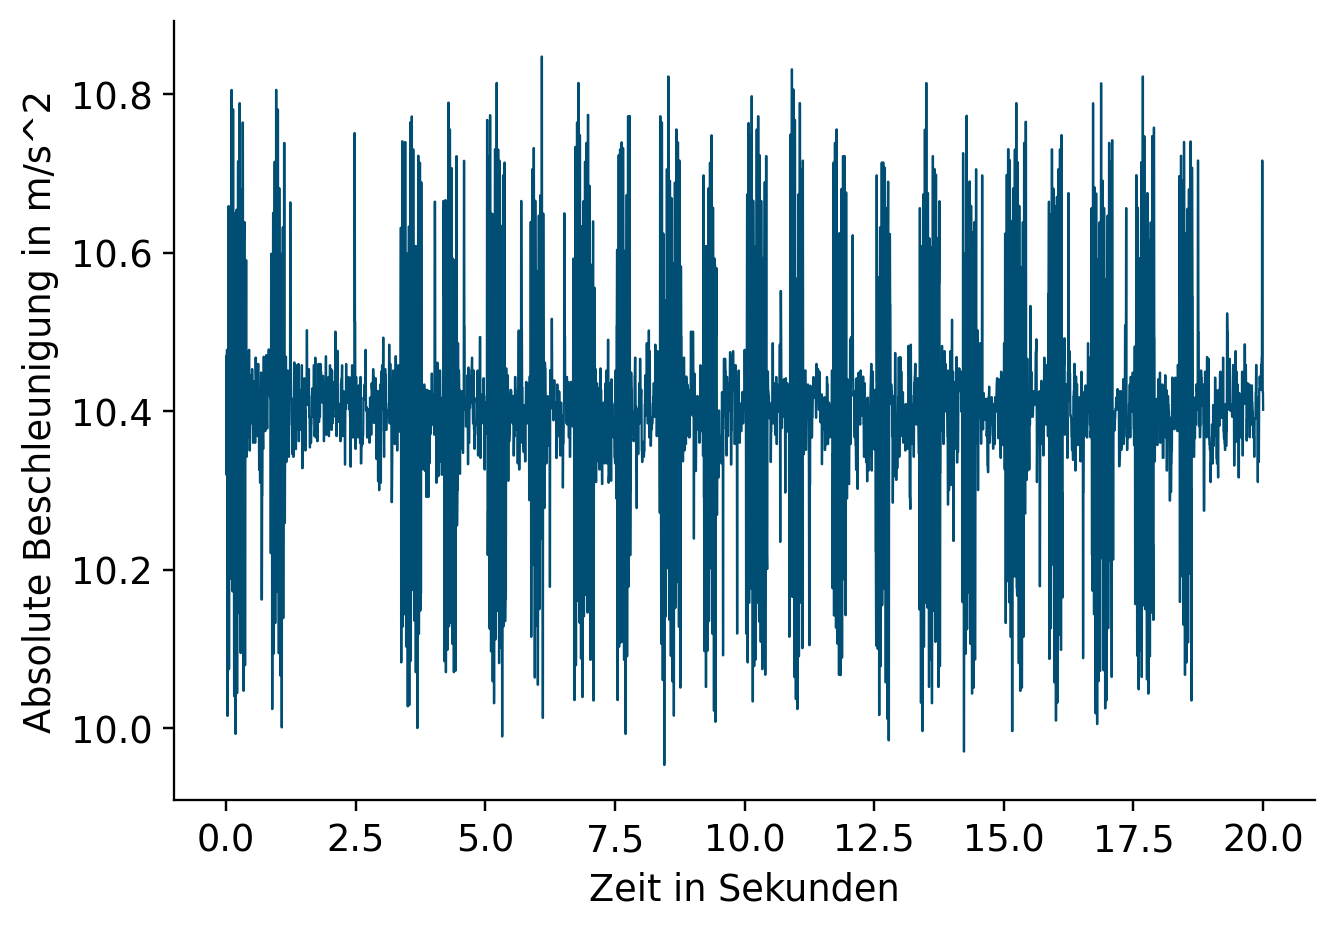

In [6]:
plt.plot(time, abs_acc)
plt.xlabel('Zeit in Sekunden')
plt.ylabel('Absolute Beschleunigung in m/s^2')

#### 4. Interpolation der Messwerte

Da es sich beim Pi nicht um ein Echtzeit-Messsystem handelt, variieren die Zeitabstände zwischen den Messwerten. Da für die FFT äquidistante Messwerte benötigt werden, ist eine Interpolation der Daten erforderlich.

In [7]:
# -------------------------------------------------------------------------------------------#4-start
# TODO: Write the function interpolation() (in m_postprocessing) to linearly interpolate the
# acceleration.
equitime, interpolated_data = interpolation(time, abs_acc)

#### 5 & 6. FFT durchführen und graphisch darstellen

Transformieren Sie die interpolierten Beträge der Beschleunigung mit der Funktion ```my_fft()``` in den Frequenzraum. Eine Skalierung der Amplitude der FFT ist nicht notwendig.
Stellen Sie die Amplitude des Signals als Funktion der Frequenz graphisch dar.

Text(0, 0.5, 'Amplitude')

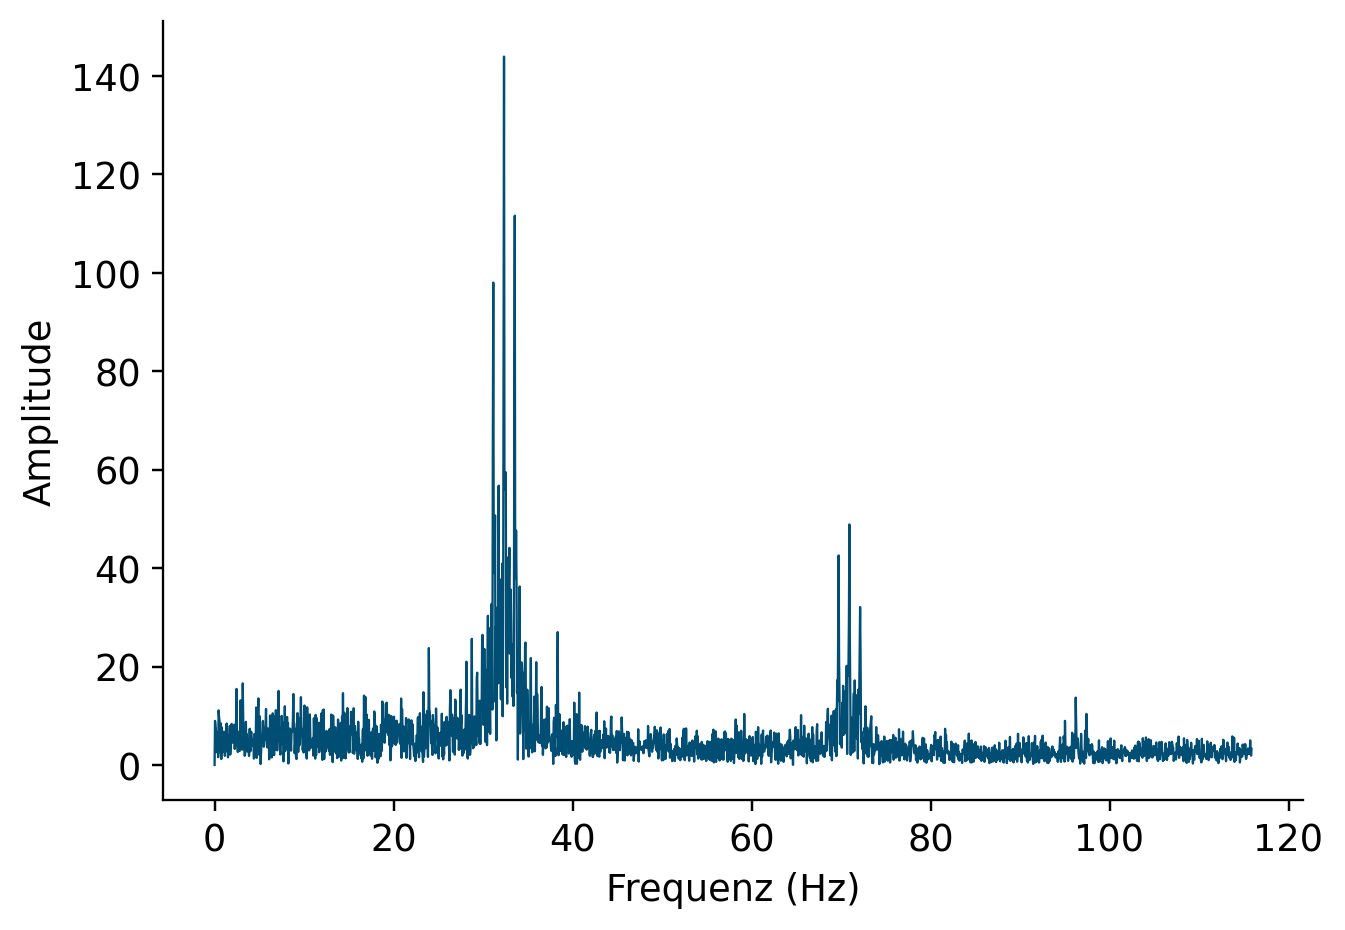

In [8]:
# -------------------------------------------------------------------------------------------#5-start
# TODO: Write my_fft() (in m_postprocessing) and plot results.
amplitude, frequency = my_fft(interpolated_data, equitime)

plt.plot(frequency, np.abs(amplitude))
plt.xlabel('Frequenz (Hz)')
plt.ylabel('Amplitude')
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Zweiter Versuch
Hier werten Sie den zweiten Gegenstand aus.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

![Ventilator.jpeg](pictures/Ventilator.jpeg)

- Beschreibung des Aufbaus: Um die Vibrationen des Ventilators zu messen, wird der Beschleunigungssensor mit Tesa-Film an den Ventilator angebracht.
- Vorgangsbeschreibung: Zur Messung der Vibrationen wird der Ventilator gestartet. Hierbei läuft er auf der höchsten Stufe und steht still (kein Rotationsmodus). Auch hier werden die Schwingungen 20 Sekunden lang gemessen.

## Versuchsauswertung

Führen Sie die obige Auswertung für den zweiten Gegenstand durch. Sie brauchen dafür nichts neu zu implementieren.

#### 1a. Einlesen der Mess- und Metadaten

In [9]:
path_measurement_folder = 'measurement_data/data_20231215_140837_ZidaneBuermann_fan'
h5_file_name = 'data_20231215_135730_ZidaneBuermann_fan.h5'

(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))

{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20231215_140837_ZidaneBuermann_fan/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20231215_140837_ZidaneBuermann_fan/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20231215_140837_ZidaneBuermann_fan/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1ee99c28-31ca-6837-a6e8-761f6ca9b302": {
    "type": "probe",
    "name": "fan",
    "comment": "",
    "path": "measurement_data/data_202

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [10]:
path = 'measurement_data/data_20231215_140837_ZidaneBuermann_fan/data_20231215_140837_ZidaneBuermann_fan.h5'
f = h5py.File(path, 'r')
datasets = f['RawData']['1ee847be-fddd-6ee4-892a-68c4555b0981']
acc_x = np.array(datasets['acceleration_x'])
acc_y = np.array(datasets['acceleration_y'])
acc_z = np.array(datasets['acceleration_z'])
time = np.array(datasets['timestamp'])

#### 2. Betrag der Beschleunigung berechnen


In [11]:
abs_acc = get_vec_accel(acc_x, acc_y, acc_z)

#### 3. Darstellung der Messdaten

Text(0, 0.5, 'Absolute Beschleunigung in m/s^2')

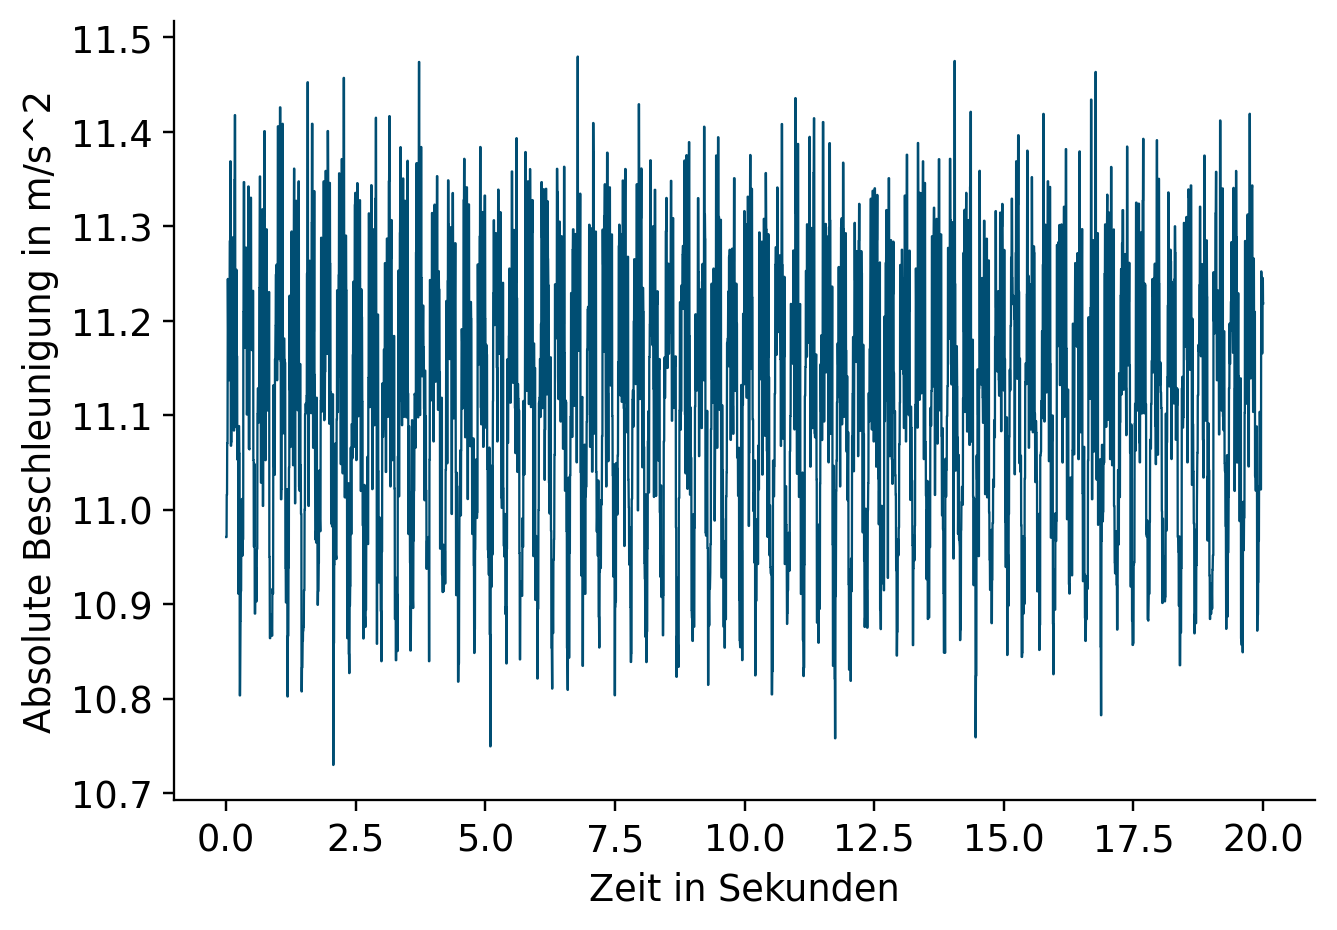

In [12]:
plt.plot(time, abs_acc)
plt.xlabel('Zeit in Sekunden')
plt.ylabel('Absolute Beschleunigung in m/s^2')

#### 4. Interpolation der Messwerte



In [13]:
equitime, interpolated_data = interpolation(time, abs_acc)

#### 5 & 6. FFT durchführen und graphisch darstellen


Text(0, 0.5, 'Amplitude')

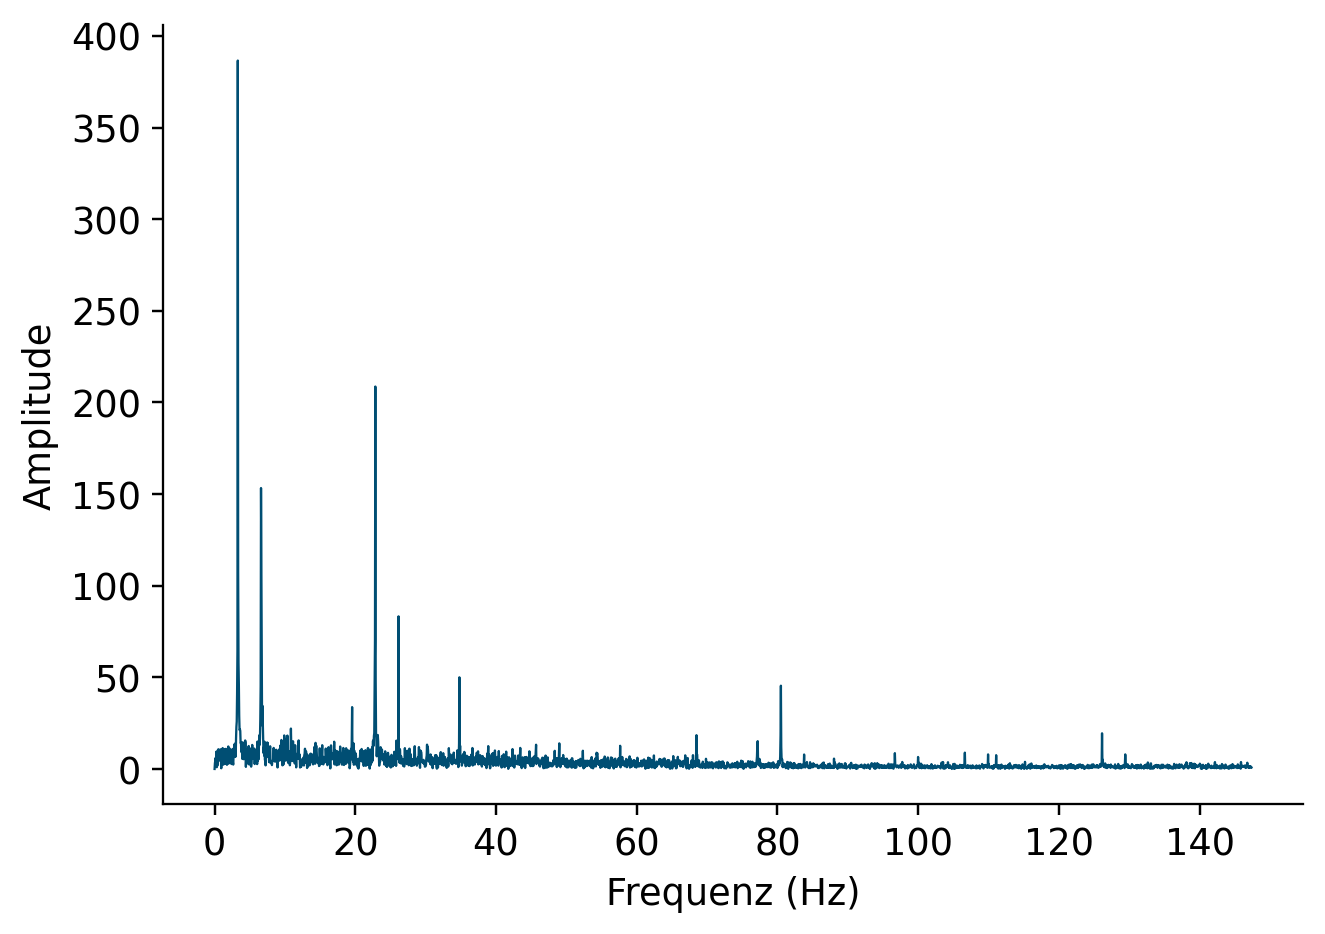

In [14]:
amplitude, frequency = my_fft(interpolated_data, equitime)

plt.plot(frequency, np.abs(amplitude))
plt.xlabel('Frequenz (Hz)')
plt.ylabel('Amplitude')

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Versuch 1: Man erkennt deutliche Peaks bei ca. 35 Hz. Nebenpeaks erkennt man rund um 70 Hz. Hieraus erkennt man die dominanten Schwingungsanteile
Versuch 2: Hier sieht man ein deutliches Maximum bei <10 Hz und Nebenmaxima bei ca. 20 Hz. Auch hier erkennt man eindeutig die dominanten Schwingungsanteile.

Rein inutitiv würde man vermuten, dass der Wecker größere Frequenzen (aufgrund der hohen Töne), aber kleinere Amplituden als der Ventilator aufweist. Dies ist hier der Fall, was auf durchaus plausible Ergebnisse deutet. Dennoch müssen die Ergebnisse aus einer kritischeren Sicht betrachtet werden, da der Versuch natürlich nicht unter "forschungsoptimalen" Bedingungen durchgeführt wurde (hinsichtlich Anzahl der Messungen, Vorbereiten der Messstände, mehrere Messsensoren, etc.). Deshalb sind die Ergebnisse intuitiv vielleicht vertrauenswürdig, für eine weitere, quantitativere Verwendung reicht es jedoch höchstwahrscheinlich nicht aus.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.


Es war sehr interessant zu erfahren, wie aus absoluten Werten (Beschleunigung) Informationen über die Schwingungen des Systems (Fouriertransformation) gewonnen werden konnten. Wieder war die Datenpflege ein sehr wichtiger Aspekt, um den Versuch und die Auswertung sauber und übersichtlich durchzuführen.
Insgesamt war es sehr interessant, sich über die Fouriertransformierte Gedanken zu machen und so Informationen wie beispielsweise dominante Frequenzanteile herauszulesen. Mir ist bewusst geworden, dass die Fouriertransformation wichtig für das Schwingverhalten eines Systems ist, welches auch einen wesentlichen Einfluss auf die Stabilität hat (Resonanzfrequenz).